In [2]:
import os
import pickle
import numpy as np
from collections import Counter

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
filex = '/home/francisco/GitHub/DQN-Event-Summarization/data/sif/train_000_0.csv'

In [4]:
sdf = pd.read_csv(filex)

In [5]:
class BoWRegressor(nn.Module):  # inheriting from nn.Module!
    # calls the init function of nn.Module.  Dont get confused by syntax, always do it in an nn.Module
    def __init__(self, input_size, outputsize):        
        super(BoWRegressor, self).__init__()        
        self.linear = nn.Linear(input_size, outputsize)
        
    def forward(self, bow_vec):
        return F.sigmoid(self.linear(bow_vec))
    
def rougeScores(genSummary, refSummary):
    genTotal, refTotal, intersection = 0, 0, 0
    for token in list(set(list(refSummary.keys()) + list(genSummary.keys()) )):
        intersection += min(refSummary[token], genSummary[token])
        refTotal += refSummary[token]
        genTotal += genSummary[token]

    recall = intersection / float(refTotal) if float(refTotal) > 0 else 0
    prec   = intersection / float(genTotal) if float(genTotal) > 0 else 0
    f1 = (2 * recall * prec) / (recall + prec) if (recall + prec) > 0 else 0
    
    return recall, prec, f1

In [6]:
recall, prec, f1 = rougeScores(Counter(sdf['summary'][0].split(" ")), Counter(sdf['sentence'][0].split(" ")))

In [7]:
recall, prec, f1

(0.2222222222222222, 0.125, 0.16)

In [8]:
sdf[sdf.columns[4:]].head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_290,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299
0,-0.032912,0.042397,0.031326,0.148815,-0.005044,0.061765,-0.042820,0.020897,-0.008707,1.360649,...,-0.155933,0.062875,-0.047902,-0.027060,-0.075693,-0.161862,-0.013952,-0.057433,-0.006306,-0.022029
1,0.019653,0.105582,-0.032739,-0.062289,-0.007770,-0.096966,-0.034363,-0.116381,0.015522,1.348884,...,-0.045381,-0.101878,-0.103699,-0.002594,-0.056704,-0.028815,0.003903,-0.038061,-0.199252,0.018881
2,0.096693,0.013868,-0.015701,-0.101575,0.068017,-0.036213,-0.031631,-0.147130,-0.026003,1.484713,...,-0.001189,-0.150899,-0.018053,0.050539,-0.083624,0.007458,0.082060,0.014343,-0.087338,-0.000591
3,0.027993,0.086192,0.170021,0.144501,0.157027,0.029404,0.058522,-0.075552,-0.037065,0.886946,...,0.101818,-0.118518,0.059976,0.031895,-0.104899,-0.052007,0.025132,0.088880,-0.156214,-0.061895
4,-0.007857,0.107740,-0.081650,-0.081380,0.005123,-0.116588,0.007774,-0.009557,0.075650,1.685651,...,-0.089699,-0.036341,-0.126280,-0.045463,-0.129258,0.005660,0.032350,-0.075145,-0.063582,-0.024497


In [9]:
sx = sdf[sdf.columns[4:]].values[0,:]

In [10]:
train_xs = torch.FloatTensor(sx.reshape(1, sx.shape[0]))
train_ys = torch.from_numpy(np.asarray([0, f1]).reshape(1,2)).float()

predsummary_emb = torch.from_numpy(np.zeros((1, 300)))

action = torch.from_numpy(np.asarray([0, 1]).reshape(1,2)).int()

In [27]:
SKIP = 0
SELECT = 1

In [11]:
model = BoWRegressor(300, 2)

model.zero_grad()
loss_function = nn.MSELoss()

In [12]:
rouge_preds = model(autograd.Variable(train_xs))
qMax, qIndx = rouge_preds.max(dim=1)

In [28]:
# Equivalent
action.select(1, qIndx.data[0]), action.select(1, 1)

(
  1
 [torch.IntTensor of size 1], 
  1
 [torch.IntTensor of size 1])

In [29]:
action[:, qIndx.data[0]]


 1
[torch.IntTensor of size 1]

In [ ]:
def buildPredSummary(sentences, currsummary, action):
    

In [24]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

lossf = {'loss': [], 'epoch': []}
for epoch in range(100):
    model.zero_grad()
    
    rouge_preds = model(autograd.Variable(train_xs))
    qMax, qIndx = rouge_preds.max(dim=1)
    action[:, qIndx.data[0]] = 1
    action[:, abs(qIndx.data[0] - 1)] = 0
    loss = loss_function(rouge_preds, autograd.Variable(train_ys))
    loss.backward()
    optimizer.step()
    lossf['loss'].append(loss.data[0])
    lossf['epoch'].append(epoch)

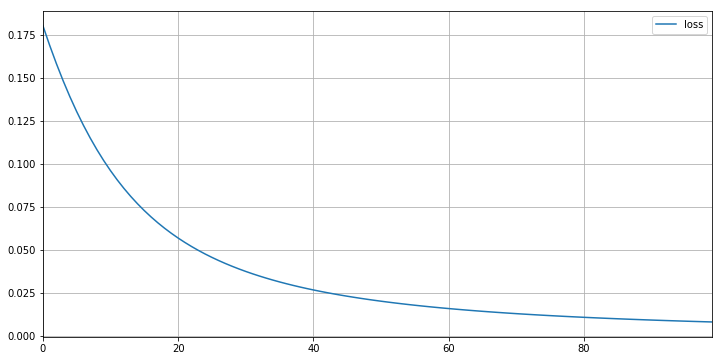

In [25]:
perf = pd.DataFrame(lossf)

perf.plot(y='loss', figsize=(12, 6))
plt.grid()
plt.show()

In [26]:
action


 0  1
[torch.IntTensor of size 1x2]

In [ ]:
-